# Reference

This Notebook is based on the tabular only notebook of another kaggler: 
https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data

In [63]:
import os
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [190]:
from pathlib import Path

root = Path(r"C:\Users\TimPr\allcode\Pytorch\kaggle_comp\isic-2024-challenge")
train_path = root / "train-metadata.csv"
test_path = root / "test-metadata.csv"
subm_path = root / "sample_submission.csv"


id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient'] + [f'{col}_count' for col in cat_cols] + [(f'{num_col}_{cat_col}') for num_col, cat_col in itertools.product(num_cols, cat_cols)]
feature_cols = num_cols + cat_cols + special_cols + norm_cols + new_num_cols

In [191]:
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            ((pl.col(num_col) - pl.col(num_col).mean().over('patient_id', cat_col)) / (pl.col(num_col).std().over('patient_id', cat_col) + err)).alias(f'{num_col}_{cat_col}') for num_col, cat_col in itertools.product(num_cols, cat_cols)
        )
        .with_columns(
            pl.col(col).count().over('patient_id', col).alias(f'{col}_count') for col in cat_cols
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

In [192]:
def preprocess(df_train, df_test):
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

In [193]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

### Data Read & Feature Engineering

In [194]:
df_train = read_data(train_path)
df_test = read_data(test_path)
df_subm = pd.read_csv(subm_path, index_col=id_col)

df_train, df_test = preprocess(df_train, df_test)



In [195]:
cnn_train = pd.read_csv(r"C:\Users\TimPr\Downloads\train_predictions (3).csv")

cnn_train['cnn_target'] = cnn_train['target']

# Merge CNN predictions with training data
df_train = df_train.merge(
    cnn_train[['isic_id', 'cnn_target']], 
    on='isic_id', 
    how='left'
)

In [196]:
df_train.cnn_target

0         0.441371
1         0.420380
2         0.444623
3         0.424005
4         0.437209
            ...   
401054    0.415349
401055    0.423164
401056    0.406917
401057    0.362881
401058    0.401084
Name: cnn_target, Length: 401059, dtype: float64

### Optuna HyperParam Tuned Models

In [79]:
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'n_jobs':           2,
    'boosting_type':    'gbdt',
    'lambda_l1':        0.03335206514282942, 
    'lambda_l2':        0.005157393323802471, 
    'learning_rate':    0.030665870185795318, 
    'max_depth':        7, 
    'num_leaves':       239, 
    'colsample_bytree': 0.7573175155547233, 
    'colsample_bynode': 0.5005423904042993, 
    'bagging_fraction': 0.7937347683420382, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 29, 
    'scale_pos_weight': 1.648349898918236,
}

cat_params = {
    'iterations': 699,
    'learning_rate': 0.025783057517242823,
    'depth': 7,
    'l2_leaf_reg': 4.754813394203791,
    'border_count': 128,
    'random_strength': 0.09925954216466397,
    'bagging_temperature': 0.16660566048110692,
    'auto_class_weights': 'Balanced',
    'random_state': 62
}
# Identify categorical feature indices
cat_feature_indices = [X.columns.get_loc(col) for col in cat_cols]

estimator = VotingClassifier([
    ('lgb', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=12)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=12)),
    ])),
    ('cat', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=62)),
        ('classifier', CatBoostClassifier(**cat_params, cat_features=cat_feature_indices)),
    ])),
], voting='soft')


In [198]:
X = df_train[feature_cols + ['cnn_target']]  # Add the 'target' feature to X
y = df_train[target_col]
groups = df_train[group_col]
cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)


## LGBoost CV Optuna search: 

In [199]:
import optuna
import lightgbm as lgb
import numpy as np
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define hyperparameter search space for LightGBM
    lgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 48),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 15.0),  # Updated range
        'max_bin': trial.suggest_int('max_bin', 64, 512),
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
    }


    # Create a single pipeline with RandomUnderSampler and LightGBM
    model = Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=12)),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=12)),
    ])

    # Calculate cross-validation score for the single model
    scores = cross_val_score(
        estimator=model,
        X=X,
        y=y,
        cv=cv,
        groups=groups,
        scoring=custom_metric,
        n_jobs=-1,  # Use parallel processing
        error_score='raise'  # Raise errors for debugging
    )
    
    return np.mean(scores)

# Create and run Optuna study
study = optuna.create_study(direction='maximize')  # Use 'minimize' if lower scores are better
study.optimize(objective, n_trials=100)  # Adjust number of trials based on your resources

# Show results
print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# To use the best parameters:
best_lgb_params = study.best_params

[I 2025-02-06 16:52:58,923] A new study created in memory with name: no-name-0e65cf6e-67b1-4c4c-90d9-644411179abd
[I 2025-02-06 16:53:33,643] Trial 0 finished with value: 0.16983674209058552 and parameters: {'n_estimators': 174, 'learning_rate': 0.16720127667166074, 'num_leaves': 1406, 'max_depth': 28, 'min_child_samples': 191, 'min_child_weight': 6.594667607901957, 'min_split_gain': 1.598103940850516, 'subsample': 0.6537726296692596, 'subsample_freq': 7, 'colsample_bytree': 0.8501529731563165, 'feature_fraction': 0.7959066625452214, 'bagging_fraction': 0.8407871533216353, 'bagging_freq': 3, 'reg_alpha': 7.617989665759372, 'reg_lambda': 6.663482433352329, 'scale_pos_weight': 3.769847663690164, 'max_bin': 356, 'extra_trees': False, 'boosting_type': 'dart', 'class_weight': None}. Best is trial 0 with value: 0.16983674209058552.
[I 2025-02-06 16:53:49,037] Trial 1 finished with value: 0.16431534354138005 and parameters: {'n_estimators': 345, 'learning_rate': 0.05209554769791874, 'num_leav

Best trial:
Value: 0.1721596164447506
Params: 
    n_estimators: 638
    learning_rate: 0.0515027285399005
    num_leaves: 411
    max_depth: 42
    min_child_samples: 19
    min_child_weight: 6.119157585293895
    min_split_gain: 3.162131795917777
    subsample: 0.8733922133329082
    subsample_freq: 10
    colsample_bytree: 0.9268501298221478
    feature_fraction: 0.7453688645895713
    bagging_fraction: 0.7902729903394483
    bagging_freq: 3
    reg_alpha: 6.13489385808673
    reg_lambda: 6.366631071435519
    scale_pos_weight: 11.65139805963427
    max_bin: 297
    extra_trees: False
    boosting_type: dart
    class_weight: None


100 trials, Best trial:
Value: 0.17475602718617683
Params: 
  *  n_estimators: 889
  *  learning_rate: 0.046466588088256
   * num_leaves: 1406
    * max_depth: 6
*    min_child_samples: 93
 *   min_child_weight: 2.046517635167626
  *  min_split_gain: 1.1517899131076044
   * subsample: 0.742206686682564
    * subsample_freq: 0
*    colsample_bytree: 0.5280979626830938
 *   feature_fraction: 0.5887906669456264
  *  bagging_fraction: 0.9335007552633481
   * bagging_freq: 8
*    reg_alpha: 0.7626351340194382
 *   reg_lambda: 0.46699594544567513
  *  scale_pos_weight: 12.23660275947521
   * max_bin: 429
*    extra_trees: False
 *   boosting_type: dart
  *  class_weight: None

# Single LGBoost model:

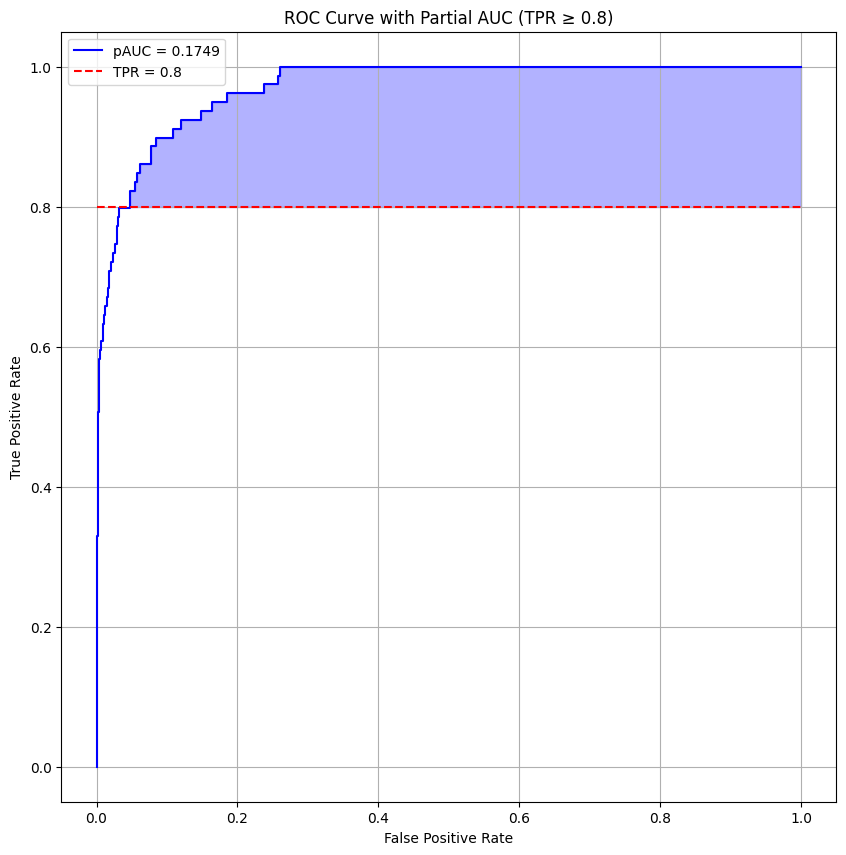

Final partial AUC: 0.1749


In [101]:
import lightgbm as lgb
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def calculate_custom_pauc(y_true, y_pred):
    """
    Calculate partial AUC using the custom method.
    """
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_pred])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# Best parameters from Optuna
best_params = {
    'n_estimators': 889,
    'learning_rate': 0.046466588088256,
    'num_leaves': 1406,
    'max_depth': 6,
    'min_child_samples': 93,
    'min_child_weight': 2.046517635167626,
    'min_split_gain': 1.1517899131076044,
    'subsample': 0.742206686682564,
    'subsample_freq': 0,
    'colsample_bytree': 0.5280979626830938,
    'feature_fraction': 0.5887906669456264,
    'bagging_fraction': 0.9335007552633481,
    'bagging_freq': 8,
    'reg_alpha': 0.7626351340194382,
    'reg_lambda': 0.46699594544567513,
    'scale_pos_weight': 12.23660275947521,
    'max_bin': 429,
    'extra_trees': False,
    'boosting_type': 'dart',
    'class_weight': None,
    'random_state': 42
}

def train_and_evaluate(X, y, sampling_ratio=0.01):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Create pipeline with best parameters
    model = Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=42)),
        ('classifier', lgb.LGBMClassifier(**best_params)),
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predictions
    y_pred = model.predict_proba(X_test)[:, 1]
    
    # Calculate custom pAUC
    final_pauc = calculate_custom_pauc(y_test, y_pred)
    
    # Create ROC curve plot
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, 'b-', label=f'pAUC = {final_pauc:.4f}')
    plt.plot([0, 1], [0.8, 0.8], 'r--', label='TPR = 0.8')
    plt.fill_between(fpr, tpr, 0.8, where=(tpr >= 0.8), alpha=0.3, color='blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Partial AUC (TPR ≥ 0.8)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, final_pauc

# Usage example:
model, pauc = train_and_evaluate(X, y)
print(f"Final partial AUC: {pauc:.4f}")

In [142]:
from catboost import CatBoostClassifier


# CatBoost CV Optuna Search

In [171]:
import optuna
from catboost import CatBoostClassifier
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
# Replace the categorical features extraction with names instead of indices
cat_features = [col for col in X.columns if X[col].dtype.name == 'category']

def objective(trial):
    # Define hyperparameter search space for CatBoost
    catboost_params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
        'auto_class_weights': 'Balanced'
    }


    # Add conditional parameters based on bootstrap_type
    if catboost_params['bootstrap_type'] == 'Bayesian':
        catboost_params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.0, 10.0)
    elif catboost_params['bootstrap_type'] == 'Bernoulli':
        catboost_params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)

    # Identify categorical features
    cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype == 'category']

    # Create pipeline with RandomUnderSampler and CatBoost
    model = Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=12)),
        ('classifier', CatBoostClassifier(
            **catboost_params,
            random_seed=12,
            verbose=False,
            allow_writing_files=False,
            cat_features=cat_features  # Pass categorical features here
        )),
    ])

    # Calculate cross-validation score
    scores = cross_val_score(
        estimator=model,
        X=X,
        y=y,
        cv=cv,
        groups=groups,
        scoring=custom_metric,
        n_jobs=-1,
        error_score='raise'
    )
    
    return np.mean(scores)

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Show results
print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# To use the best parameters:
best_catboost_params = study.best_params

[I 2025-02-06 03:00:53,069] A new study created in memory with name: no-name-06ad400b-09af-4ced-872d-8e55d68f1e1b
[I 2025-02-06 03:01:58,511] Trial 0 finished with value: 0.16408665092861446 and parameters: {'iterations': 626, 'learning_rate': 0.017626941615097973, 'depth': 7, 'l2_leaf_reg': 2.0521730592567575, 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 60, 'leaf_estimation_method': 'Gradient', 'random_strength': 1.6294874261929946, 'subsample': 0.7437475613828837}. Best is trial 0 with value: 0.16408665092861446.
[I 2025-02-06 03:02:31,835] Trial 1 finished with value: 0.1639494870870989 and parameters: {'iterations': 558, 'learning_rate': 0.03233820550997977, 'depth': 5, 'l2_leaf_reg': 0.43079439662382707, 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 45, 'leaf_estimation_method': 'Gradient', 'random_strength': 6.586005791690408, 'bagging_temperature': 4.816876985129996}. Best is trial 0 with value: 0.16408665092861446.
[I 2025-02-06 03:07:45,524] Trial 2 finished with va

Best trial:
Value: 0.1715847745121224
Params: 
    iterations: 622
    learning_rate: 0.017109499449623276
    depth: 6
    l2_leaf_reg: 9.771336303421986
    bootstrap_type: Bernoulli
    min_data_in_leaf: 55
    leaf_estimation_method: Newton
    random_strength: 0.25330511611966006
    subsample: 0.9754112307979648


30 trials, Best trial:
Value: 0.1716365923808929
Params: 
    iterations: 699
    learning_rate: 0.025783057517242823
    depth: 7
    l2_leaf_reg: 4.754813394203791
    border_count: 128
    random_strength: 0.09925954216466397
    bagging_temperature: 0.16660566048110692
    auto_class_weights: Balanced

### Cross Validation

In [141]:
X = df_train[feature_cols + ['cnn_target']]  # Add the 'target' feature to X
y = df_train[target_col]
groups = df_train[group_col]
cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)


In [182]:
lgb_params = {
    'objective': 'binary',  # Ensure the objective is set correctly
    'n_estimators': 889,    # Number of boosting rounds
    'learning_rate': 0.046466588088256,
    'num_leaves': 63,       # Reduced from 1406 to a more reasonable value
    'max_depth': 6,
    'min_child_samples': 20,  # Reduced from 93 to allow more splits
    'min_child_weight': 1.0,  # Less restrictive than 2.046517635167626
    'min_split_gain': 0.1,    # Reduced from 1.1517899131076044
    'subsample': 0.742206686682564,
    'subsample_freq': 0,
    'colsample_bytree': 0.5280979626830938,
    'feature_fraction': 0.5887906669456264,
    'bagging_fraction': 0.9335007552633481,
    'bagging_freq': 8,
    'reg_alpha': 0.7626351340194382,
    'reg_lambda': 0.46699594544567513,
    'scale_pos_weight': 10.0,  # Reduced from 12.23660275947521
    'max_bin': 429,
    'boosting_type': 'gbdt',  # Use 'gbdt' instead of 'dart' for stability
    'class_weight': None,
    'verbosity': -1,          # Suppress LightGBM logs
}

cat_params = {
    'iterations': 622,
    'learning_rate': 0.017109499449623276,
    'depth': 6,
    'l2_leaf_reg': 9.771336303421986,
    'bootstrap_type': 'Bernoulli',
    'min_data_in_leaf': 55,
    'leaf_estimation_method': 'Newton',
    'random_strength': 0.25330511611966006,
    'subsample': 0.9754112307979648,
    'border_count': 128,
    # 'bagging_temperature': 0.16660566048110692,
    'auto_class_weights': 'Balanced',
}

# Identify categorical feature indices
cat_feature_indices = [X.columns.get_loc(col) for col in cat_cols]
# List of unique random states for each pipeline (doubled)
random_states = [
    12, 24, 48, 96, 192, 6, 18, 36, 72, 144, 288, 9,
    50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600
]

# Estimator with 24 models (doubled the number of LGBM models)
estimator = VotingClassifier([
    ('lgb1', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[0])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[0])),
    ])),
    ('lgb2', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[1])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[1])),
    ])),
    ('lgb3', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[2])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[2])),
    ])),
    ('lgb4', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[3])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[3])),
    ])),
    ('lgb5', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[4])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[4])),
    ])),
    ('lgb6', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[5])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[5])),
    ])),
    ('lgb7', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[6])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[6])),
    ])),
    ('lgb8', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[7])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[7])),
    ])),
    ('lgb9', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[8])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[8])),
    ])),
    ('lgb10', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[9])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[9])),
    ])),
    ('lgb11', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[10])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[10])),
    ])),
    ('lgb12', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=random_states[11])),
        ('classifier', lgb.LGBMClassifier(**lgb_params, random_state=random_states[11])),
    ])),
    ('cat1', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=42)),
        ('classifier', CatBoostClassifier(**cat_params, cat_features=cat_feature_indices)),
    ])),
    ('cat2', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=48)),
        ('classifier', CatBoostClassifier(**cat_params, cat_features=cat_feature_indices)),
    ])),    
    # ('cat3', Pipeline([
    #     ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=69)),
    #     ('classifier', CatBoostClassifier(**cat_params, cat_features=cat_feature_indices)),
    # ])),
    # ('cat4', Pipeline([
    #     ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=72)),
    #     ('classifier', CatBoostClassifier(**cat_params, cat_features=cat_feature_indices)),
    # ])),  
], voting='soft')


In [197]:
X = df_train[feature_cols + ['cnn_target']]
y = df_train[target_col]
groups = df_train[group_col]
cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)

val_score = cross_val_score(
    estimator=estimator, 
    X=X, y=y, 
    cv=cv, 
    groups=groups,
    scoring=custom_metric,
)

print("Mean Validation Score:", np.mean(val_score))
print("All Validation Scores:", val_score)


0:	learn: 0.6758663	total: 37.6ms	remaining: 23.4s
1:	learn: 0.6601773	total: 71.4ms	remaining: 22.1s
2:	learn: 0.6441885	total: 105ms	remaining: 21.7s
3:	learn: 0.6291963	total: 139ms	remaining: 21.5s
4:	learn: 0.6143926	total: 172ms	remaining: 21.2s
5:	learn: 0.6005479	total: 204ms	remaining: 20.9s
6:	learn: 0.5873130	total: 237ms	remaining: 20.8s
7:	learn: 0.5750543	total: 269ms	remaining: 20.6s
8:	learn: 0.5633953	total: 302ms	remaining: 20.6s
9:	learn: 0.5507242	total: 342ms	remaining: 20.9s
10:	learn: 0.5383318	total: 393ms	remaining: 21.8s
11:	learn: 0.5272645	total: 434ms	remaining: 22s
12:	learn: 0.5167170	total: 471ms	remaining: 22.1s
13:	learn: 0.5057069	total: 511ms	remaining: 22.2s
14:	learn: 0.4966306	total: 548ms	remaining: 22.2s
15:	learn: 0.4869345	total: 584ms	remaining: 22.1s
16:	learn: 0.4783775	total: 625ms	remaining: 22.2s
17:	learn: 0.4691614	total: 664ms	remaining: 22.3s
18:	learn: 0.4607369	total: 702ms	remaining: 22.3s
19:	learn: 0.4531753	total: 739ms	remaini

1LGB:0.17160361833037005
1Cat: Mean Validation Score: 0.16877630993724888
4Cat: Mean Validation Score: 0.17032293942424648
3LGB, 2Cat: 0.1731
3LGB: Mean Validation Score: 0.1725557552033449
6LGB: Mean Validation Score: 0.17352512699800776
12LGB: Mean Validation Score: 0.17401482885091818
24LGB: Mean Validation Score: 0.1739839001037864
12LGB + 2Cat: Mean Validation Score: 0.17462689939098802


### Training

In [81]:
X, y = df_train[feature_cols], df_train[target_col]

estimator.fit(X, y)

0:	learn: 0.6641288	total: 43.4ms	remaining: 30.3s
1:	learn: 0.6363172	total: 77.8ms	remaining: 27.1s
2:	learn: 0.6111515	total: 113ms	remaining: 26.2s
3:	learn: 0.5871163	total: 145ms	remaining: 25.3s
4:	learn: 0.5654581	total: 186ms	remaining: 25.8s
5:	learn: 0.5449885	total: 220ms	remaining: 25.4s
6:	learn: 0.5255664	total: 254ms	remaining: 25.1s
7:	learn: 0.5064286	total: 290ms	remaining: 25.1s
8:	learn: 0.4886342	total: 325ms	remaining: 24.9s
9:	learn: 0.4737644	total: 358ms	remaining: 24.7s
10:	learn: 0.4591102	total: 395ms	remaining: 24.7s
11:	learn: 0.4454371	total: 428ms	remaining: 24.5s
12:	learn: 0.4307684	total: 463ms	remaining: 24.4s
13:	learn: 0.4154834	total: 500ms	remaining: 24.5s
14:	learn: 0.4042234	total: 536ms	remaining: 24.4s
15:	learn: 0.3921461	total: 570ms	remaining: 24.3s
16:	learn: 0.3836993	total: 609ms	remaining: 24.4s
17:	learn: 0.3738280	total: 642ms	remaining: 24.3s
18:	learn: 0.3646448	total: 675ms	remaining: 24.2s
19:	learn: 0.3548636	total: 711ms	remai

VotingClassifier(estimators=[('lgb',
                              Pipeline(steps=[('sampler',
                                               RandomUnderSampler(random_state=12,
                                                                  sampling_strategy=0.01)),
                                              ('classifier',
                                               LGBMClassifier(bagging_fraction=0.7937347683420382,
                                                              bagging_freq=4,
                                                              colsample_bynode=0.5005423904042993,
                                                              colsample_bytree=0.7573175155547233,
                                                              lambda_l1=0.03335206514282942,
                                                              lambda_l2=0.005157393323802471,
                                                              learning_rate=...795318,
                                                              max_depth=7,
                                                              min_data_in_leaf=29,
                                                              n_iter=200,
                                                              n_jobs=2,
                                                              num_leaves=239,
                                                              objective='binary',
                                                              random_state=12,
                                                              scale_pos_weight=1.648349898918236,
                                                              verbosity=-1))])),
                             ('cat',
                              Pipeline(steps=[('sampler',
                                               RandomUnderSampler(random_state=62,
                                                                  sampling_strategy=0.01)),
                                              ('classifier',
                                               <catboost.core.CatBoostClassifier object at 0x0000024C835AEE90>)]))],
                 voting='soft')

### Prediction

In [82]:
df_subm['target'] = estimator.predict_proba(df_test[feature_cols])[:, 1]

df_subm.to_csv('submission.csv')
df_subm.head()

,target
isic_id,
ISIC_0015657,0.809460
ISIC_0015729,0.629460
ISIC_0015740,0.796416
